In [2]:
!pip install timm
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from timm.utils import ModelEmaV3
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

#positional embeddings
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None]

In [4]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv1d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [5]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        length = x.shape[2]
        x = rearrange(x, 'b c l -> b l c')
        x = self.proj1(x)
        x = rearrange(x, 'b l (C H K) -> K b H l C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H l C -> b l (C H)')
        x = self.proj2(x)
        return rearrange(x, 'b l C -> b C l')

In [6]:
class UnetLayer(nn.Module):
    def __init__(self,
            upscale: bool,
            attention: bool,
            last_layer: bool,
            num_groups: int,
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale and not last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=3, stride=2, padding=1)
        elif last_layer:
            self.conv = nn.ConvTranspose1d(C, C//2, kernel_size=3, stride=2, padding=1, output_padding=1)
        else:
            self.conv = nn.Conv1d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

In [7]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            last_layers: List = [False, False, False, False, False, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv1d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv1d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv1d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                last_layer=last_layers[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

In [8]:
model = UNET()

# Generate a random 1D input tensor of shape (batch_size, input_channels, length)
batch_size = 1  # You can change this to whatever batch size you need
input_length = 34  # As specified
input_tensor = torch.randn(batch_size, 1, input_length)  # Shape: (1, 1, 34)

# Generate a random time step tensor
time_steps = torch.randint(0, 1000, (batch_size,))  # Randomly generating time steps

# Pass the input tensor through the model
output = model(input_tensor, time_steps)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 34])


In [9]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [10]:
#optional set seed
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [11]:
data = np.load('/kaggle/input/1mil-pixel-data/1mil_pixel_data.npy')
#reshape it to (size, channels, length)
data = data.reshape((-1, 1, 34))
data.shape

(1000000, 1, 34)

In [12]:
class SpectralDataset(Dataset):
  def __init__(self, data):
    self.data = torch.from_numpy(data)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [22]:
import os
def train(batch_size: int=250,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,
          lr=2e-5,
          checkpoint_path: str=None):
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_dataset = SpectralDataset(data)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, x in enumerate(tqdm(train_dataloader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            t = torch.randint(0,num_time_steps,(batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size,1,1).cuda()
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (1000000/batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    torch.save(checkpoint, '/kaggle/working/ddpm_checkpoint.pth')

In [23]:
train(checkpoint_path='/kaggle/working/ddpm_checkpoint.pth', lr=2e-5, num_epochs=100)

Epoch 1/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.92it/s]


Epoch 1 | Loss 0.03670


Epoch 2/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.93it/s]


Epoch 2 | Loss 0.00526


Epoch 3/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.93it/s]


Epoch 3 | Loss 0.00335


Epoch 4/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.93it/s]


Epoch 4 | Loss 0.00263


Epoch 5/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 5 | Loss 0.00220


Epoch 6/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 6 | Loss 0.00194


Epoch 7/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 7 | Loss 0.00172


Epoch 8/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.95it/s]


Epoch 8 | Loss 0.00160


Epoch 9/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 9 | Loss 0.00150


Epoch 10/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 10 | Loss 0.00140


Epoch 11/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 11 | Loss 0.00132


Epoch 12/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 12 | Loss 0.00126


Epoch 13/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.99it/s]


Epoch 13 | Loss 0.00121


Epoch 14/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 14 | Loss 0.00116


Epoch 15/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 15 | Loss 0.00112


Epoch 16/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 16 | Loss 0.00106


Epoch 17/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.99it/s]


Epoch 17 | Loss 0.00105


Epoch 18/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 18 | Loss 0.00099


Epoch 19/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 19 | Loss 0.00099


Epoch 20/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 20 | Loss 0.00095


Epoch 21/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 21 | Loss 0.00093


Epoch 22/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.99it/s]


Epoch 22 | Loss 0.00093


Epoch 23/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 23 | Loss 0.00091


Epoch 24/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.95it/s]


Epoch 24 | Loss 0.00090


Epoch 25/100: 100%|██████████| 4000/4000 [05:11<00:00, 12.84it/s]


Epoch 25 | Loss 0.00088


Epoch 26/100: 100%|██████████| 4000/4000 [05:12<00:00, 12.82it/s]


Epoch 26 | Loss 0.00087


Epoch 27/100: 100%|██████████| 4000/4000 [05:12<00:00, 12.81it/s]


Epoch 27 | Loss 0.00086


Epoch 28/100: 100%|██████████| 4000/4000 [05:12<00:00, 12.81it/s]


Epoch 28 | Loss 0.00085


Epoch 29/100: 100%|██████████| 4000/4000 [05:11<00:00, 12.84it/s]


Epoch 29 | Loss 0.00084


Epoch 30/100: 100%|██████████| 4000/4000 [05:11<00:00, 12.84it/s]


Epoch 30 | Loss 0.00083


Epoch 31/100: 100%|██████████| 4000/4000 [05:11<00:00, 12.83it/s]


Epoch 31 | Loss 0.00082


Epoch 32/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 32 | Loss 0.00083


Epoch 33/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 33 | Loss 0.00082


Epoch 34/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 34 | Loss 0.00080


Epoch 35/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 35 | Loss 0.00080


Epoch 36/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 36 | Loss 0.00080


Epoch 37/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 37 | Loss 0.00079


Epoch 38/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 38 | Loss 0.00079


Epoch 39/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 39 | Loss 0.00078


Epoch 40/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 40 | Loss 0.00079


Epoch 41/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.95it/s]


Epoch 41 | Loss 0.00077


Epoch 42/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 42 | Loss 0.00077


Epoch 43/100: 100%|██████████| 4000/4000 [05:09<00:00, 12.94it/s]


Epoch 43 | Loss 0.00075


Epoch 44/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 44 | Loss 0.00075


Epoch 45/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 45 | Loss 0.00075


Epoch 46/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 46 | Loss 0.00074


Epoch 47/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 47 | Loss 0.00075


Epoch 48/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 48 | Loss 0.00074


Epoch 49/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 49 | Loss 0.00074


Epoch 50/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 50 | Loss 0.00075


Epoch 51/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.99it/s]


Epoch 51 | Loss 0.00074


Epoch 52/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 52 | Loss 0.00074


Epoch 53/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 53 | Loss 0.00072


Epoch 54/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 54 | Loss 0.00073


Epoch 55/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 55 | Loss 0.00073


Epoch 56/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 56 | Loss 0.00072


Epoch 57/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 57 | Loss 0.00071


Epoch 58/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 58 | Loss 0.00072


Epoch 59/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 59 | Loss 0.00072


Epoch 60/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 60 | Loss 0.00070


Epoch 61/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 61 | Loss 0.00071


Epoch 62/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 62 | Loss 0.00070


Epoch 63/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 63 | Loss 0.00070


Epoch 64/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 64 | Loss 0.00070


Epoch 65/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 65 | Loss 0.00071


Epoch 66/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 66 | Loss 0.00069


Epoch 67/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 67 | Loss 0.00070


Epoch 68/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 68 | Loss 0.00069


Epoch 69/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 69 | Loss 0.00069


Epoch 70/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 70 | Loss 0.00068


Epoch 71/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 71 | Loss 0.00068


Epoch 72/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 72 | Loss 0.00068


Epoch 73/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 73 | Loss 0.00067


Epoch 74/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 74 | Loss 0.00068


Epoch 75/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 75 | Loss 0.00068


Epoch 76/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 76 | Loss 0.00068


Epoch 77/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 77 | Loss 0.00067


Epoch 78/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.99it/s]


Epoch 78 | Loss 0.00068


Epoch 79/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 79 | Loss 0.00067


Epoch 80/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 80 | Loss 0.00067


Epoch 81/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 81 | Loss 0.00066


Epoch 82/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 82 | Loss 0.00066


Epoch 83/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 83 | Loss 0.00065


Epoch 84/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 84 | Loss 0.00067


Epoch 85/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 85 | Loss 0.00066


Epoch 86/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 86 | Loss 0.00066


Epoch 87/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 87 | Loss 0.00065


Epoch 88/100: 100%|██████████| 4000/4000 [05:07<00:00, 12.99it/s]


Epoch 88 | Loss 0.00066


Epoch 89/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 89 | Loss 0.00065


Epoch 90/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 90 | Loss 0.00065


Epoch 91/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 91 | Loss 0.00064


Epoch 92/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 92 | Loss 0.00066


Epoch 93/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 93 | Loss 0.00065


Epoch 94/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.96it/s]


Epoch 94 | Loss 0.00065


Epoch 95/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 95 | Loss 0.00065


Epoch 96/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 96 | Loss 0.00065


Epoch 97/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 97 | Loss 0.00066


Epoch 98/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 98 | Loss 0.00065


Epoch 99/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.97it/s]


Epoch 99 | Loss 0.00065


Epoch 100/100: 100%|██████████| 4000/4000 [05:08<00:00, 12.98it/s]


Epoch 100 | Loss 0.00064


In [13]:
def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999, ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    spectra = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 1, 34)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/((torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t]))))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                #if t[0] in times:
                    #spectra.append(z.clone())
                e = torch.randn(1, 1, 34)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/((torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())

            x = x.squeeze(0).detach().numpy()
            spectra.append(x)
    return spectra

In [14]:
spectra = inference('/kaggle/input/ddpm-checkpoint/ddpm_checkpoint.pth')

/tmp/ipykernel_30/734865899.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [22]:
data = np.load("/kaggle/input/1mil-pixel-data/1mil_pixel_data.npy")

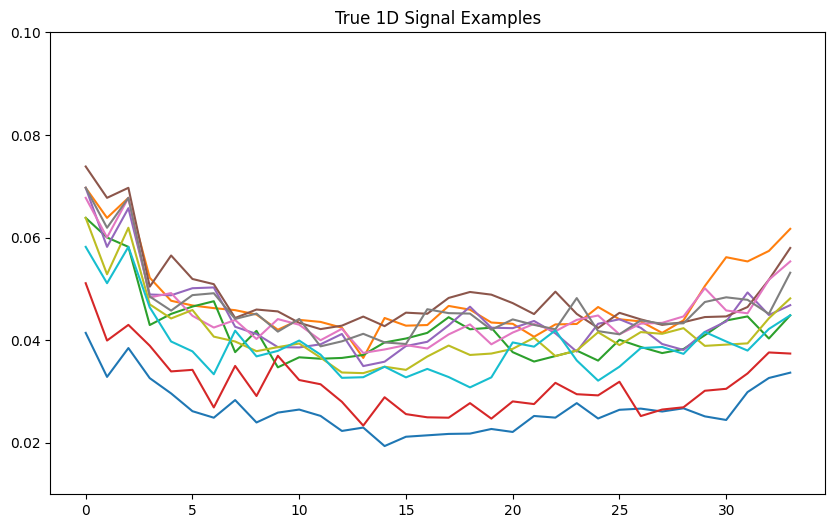

In [28]:
import random
plt.figure(figsize=(10, 6))
for i in range(10):
  rand = random.randint(0,1000000)
  plt.plot(data[rand])
plt.ylim(0.01,0.1)
plt.title("True 1D Signal Examples");

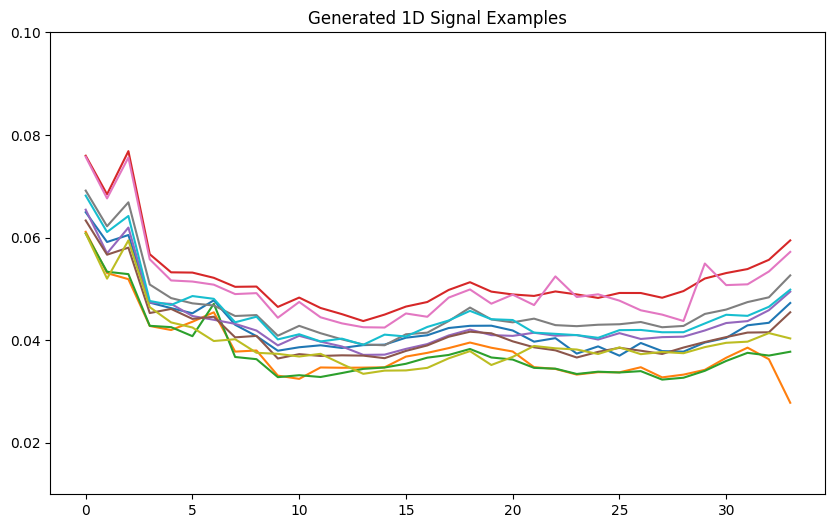

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i, spectrum in enumerate(spectra):
    # Squeeze the array to get rid of extra dimensions
    spectrum = spectrum.squeeze()
    plt.plot(range(34), spectrum)
    
plt.title('Generated 1D Signal Examples')
plt.ylim(0.01,0.1);